# Install requirements

In [ ]:
! pip install pandas
! pip install transformers datasets evaluate rouge_score
! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

## Import requirements

In [ ]:
import pandas as pd
import csv
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


# Load dataset

In [117]:
df = pd.read_csv('booksummaries.csv', delimiter='\t' , names=["Path", "Title", "Author","Date", "Info", "Text"])

# Data Cleaning 

### Check missing values

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16559 entries, 620 to 37159503
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Path    16559 non-null  object
 1   Title   16559 non-null  object
 2   Author  14177 non-null  object
 3   Date    10949 non-null  object
 4   Info    12841 non-null  object
 5   Text    16559 non-null  object
dtypes: object(6)
memory usage: 905.6+ KB


### Our project primarily relies on the 'Text' column, which is free from NaN values. To maintain data completeness, any missing values in other columns are replaced with designated values rather than being removed.

In [119]:
df['Author'] = df['Author'].fillna("unknown")
df['Date'] = df['Date'].apply(lambda x: int(x[:4]) if isinstance(x, str) and x[:4].isdigit() else -1)
df['Info'] = df['Info'].fillna("{}")
df = df.reset_index(drop = True)



### checking the result

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16559 entries, 0 to 16558
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Path    16559 non-null  object
 1   Title   16559 non-null  object
 2   Author  16559 non-null  object
 3   Date    16559 non-null  int64 
 4   Info    16559 non-null  object
 5   Text    16559 non-null  object
dtypes: int64(1), object(5)
memory usage: 776.3+ KB


# Exploratory Data Analysis

### 1- Explore the dataset's genre distribution. Show the top 10 most frequent genres visually.


In [121]:
genres = {}
info = df.Info.to_list()
for i in range(len(info)):
    tmp = json.loads(info[i])
    for _, value in tmp.items():
        if value in genres:
            genres[value] += 1
        else:
            genres[value] = 1



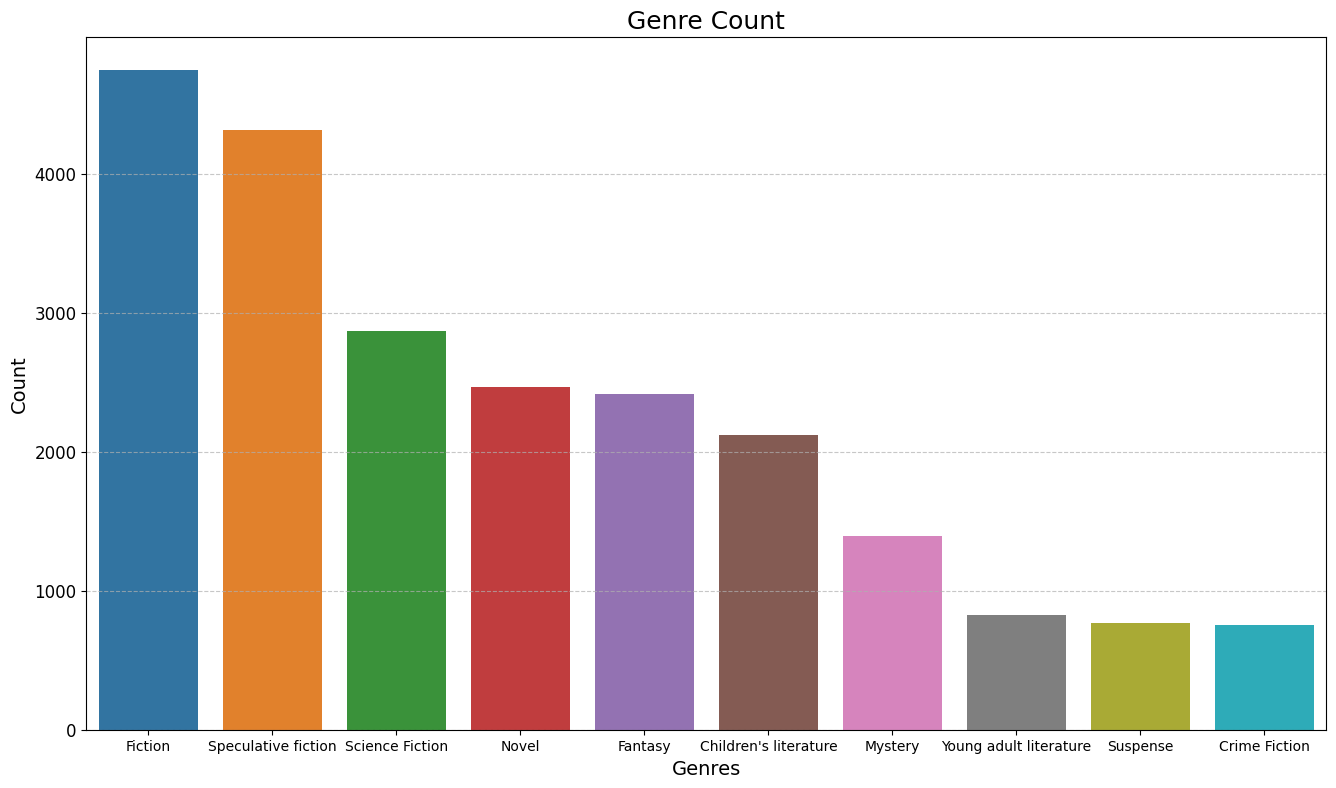

In [122]:
sorted_genres = dict(sorted(genres.items(), key=lambda x: x[1], reverse=True))
top_10_genres = dict(list(sorted_genres.items())[:10])

plt.figure(figsize=(16, 9))

palette = sns.color_palette("tab10")

sns.barplot(x=list(top_10_genres.keys()), y=list(top_10_genres.values()), palette=palette)


plt.title('Genre Count', fontsize=18)
plt.xlabel('Genres', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.xticks(fontsize=10)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


### 2- Showing the distribution of different types of fiction books throughout the years


In [ ]:
year = df[df['Date'] > 1800]['Date'].tolist()
genre = df[df['Date'] > 1800]['Info'].tolist()
years = []
genras = []
for i in range(len(genre)):
    tmp = json.loads(genre[i])
    for _, value in tmp.items():
        if value in ['Science Fiction', 'Crime Fiction', 'Speculative fiction', 'Horror']:
            years.append(year[i])
            genras.append(value)




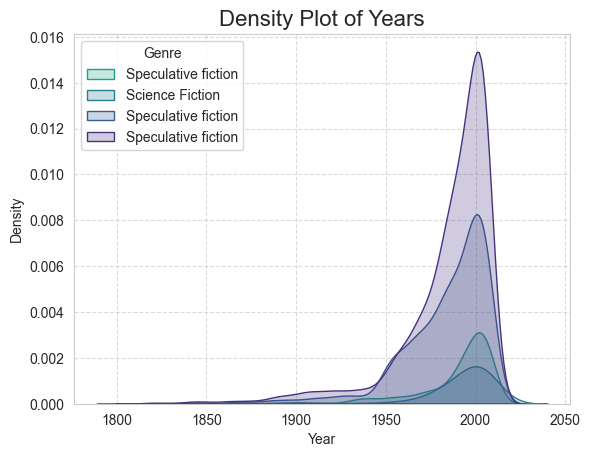

In [123]:
sns.set_style("whitegrid")
sns.set_palette("viridis")

sns.kdeplot(x=years , hue = genras, shade=True)




plt.xlabel('Year')
plt.ylabel('Density')
plt.title('Density Plot of Years')
plt.legend(genras, loc='upper left', title="Genre")
plt.title('Density Plot of Years', fontsize=16)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()


# Summarization

### download the selected model for summarization

In [71]:
import torch
from transformers import pipeline

summarizer = pipeline(
    "summarization",
    "pszemraj/long-t5-tglobal-base-16384-book-summary",
    device=0 if torch.cuda.is_available() else -1,
)

long_text = "Here is a lot of text I don't want to read. Replace me"

result = summarizer(long_text)
print(result[0]["summary_text"])

Your max_length is set to 512, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


This is a very long list of text I do not want to read, replace me with you. Replace me.


### use model for all books and save them in a list 

In [ ]:
summaries = []

for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
    summary = summarizer(row["Text"])
    summaries.append(summary)
    if (index) % 5 == 0:
        torch.cuda.empty_cache()



### saving the results into a csv file 

In [ ]:
# import csv
# result_file = open("Summaries.csv",'wb')
# with open('output2.csv','w') as result_file:
#     wr = csv.writer(result_file, dialect='excel')
#     wr.writerows(summaries)

### load the results in future uses 

In [133]:

Summaries = pd.read_csv('Summaries.csv' , names=['Summaries'])
Summaries.head(5)


Summaries
0  {'summary_text': 'Old Major calls the animals ...
1  {'summary_text': 'The narrator introduces us t...
2  {'summary_text': "The novel opens with a descr...
3  {'summary_text': 'Hume begins the book by intr...
4  {'summary_text': 'The novel opens with a descr...

In [134]:
summaries = Summaries['Summaries'].to_list()

### Cleaning the results of summaries 

In [135]:
for i in range(len(summaries)):
    summaries[i] = json.loads(summaries[i]
                              .replace('\\', '')
                              .replace('"', '\\"')
                              .replace('{\'summary_text\': \'', '{"summary_text": "')
                              .replace('{\'summary_text\': \\"', '{"summary_text": "')
                              .replace('{\\"summary_text\\": \\"', '{"summary_text": "')
                              .replace('\'}', '"}')
                              .replace('\\\"}', '"}')
                              )['summary_text']



### Add summaries as a our main dataset coloumn 

In [136]:
df['Summaries'] = summaries


### Displaying Some Randomly Selected Summarized Text with Associated Book Titles

In [149]:
from IPython.display import HTML

# Assuming df is your DataFrame with columns 'Title' and 'Summaries'

# Select 9 random rows from the DataFrame
random_rows = df.sample(n=9)

# Create a HTML display for better readability, with title color set to deep blue
html = '<div style="font-family: Arial; font-size: 14px;">'
for index, row in random_rows.iterrows():
    html += f'<h3 style="color: #0080ff;">{row["Title"]}</h3><p>{row["Summaries"][:2000]}{"..." if len(row["Summaries"]) > 2000 else ""}</p>'
html += '</div>'

# Display the formatted HTML
display(HTML(html))



# Text-to-Image 

### download the selected model 

In [59]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")






Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

### creating photos with summarized text

In [ ]:
photo_names = []


for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
    name = str(index)+'_'+str(row['Title'])+'.png'
    prompt = row['Summaries']
    photo = pipe(prompt).images[0]
    try:
        photo.save(f'images/{name}') 
    except:
        photo.save(str(index)+'.png')
    photo_names.append(name)
    if (index) % 5 == 0:
        torch.cuda.empty_cache()




## mistakes correction

### some files didn't save properly 

In [ ]:

arr = os.listdir('images/')

for i, value in tqdm(enumerate(arr), total=len(arr)):
    if value.endswith('.png'):
        continue

    else:
        try:
            os.remove(f"images/{value}")
            name = value + '.png'
            index = int(value.split('_')[0])
            prompt = df.loc[index]['Summaries']
            photo = pipe(prompt).images[0]
            try:
                photo.save(f'images/{name}') 
            except:
                photo.save("images/" + str(index)+'.png')
            # photo_names.append(name)
            if (i) % 5 == 0:
                torch.cuda.empty_cache()
        except:
            continue



### a function designed to detect black images

In [36]:
from PIL import Image

def is_image_all_black(image_path):
    img = Image.open(image_path)
    img = img.convert('L')
    pixels = img.getdata()  
    return all(pixel == 0 for pixel in pixels)




The image is not completely black.


### Removing the black images 

In [106]:
arr = os.listdir('images/')

for i, value in tqdm(enumerate(arr), total=len(arr)):
    try:

        if is_image_all_black(f'images/{value}'):
                os.remove(f"images/{value}")

    except:
        continue



100%|██████████| 16559/16559 [03:18<00:00, 83.48it/s]


### Double Summarization to Navigate Policy Constraints

In [109]:
arr = os.listdir('images/')

index_list = []
for i in arr:
    try:
        index_list.append(int(i.split('_')[0]))
    except:
        index_list.append(int(i.split('.')[0]))


In [ ]:
for i in range(len(df)):
    if not i in index_list:
        print(f"------------------------------------------------------- {i} ---------------------------------------------------")
        prompt = df.iloc[i]['Summaries']
        prompt = summarizer(prompt)[0]['summary_text']
        photo = pipe(prompt).images[0]
        photo.save(f"{i}.png")

        if (i) % 3 == 0:
            torch.cuda.empty_cache()
        



### Displaying Some Random Images with Associated Book Titles

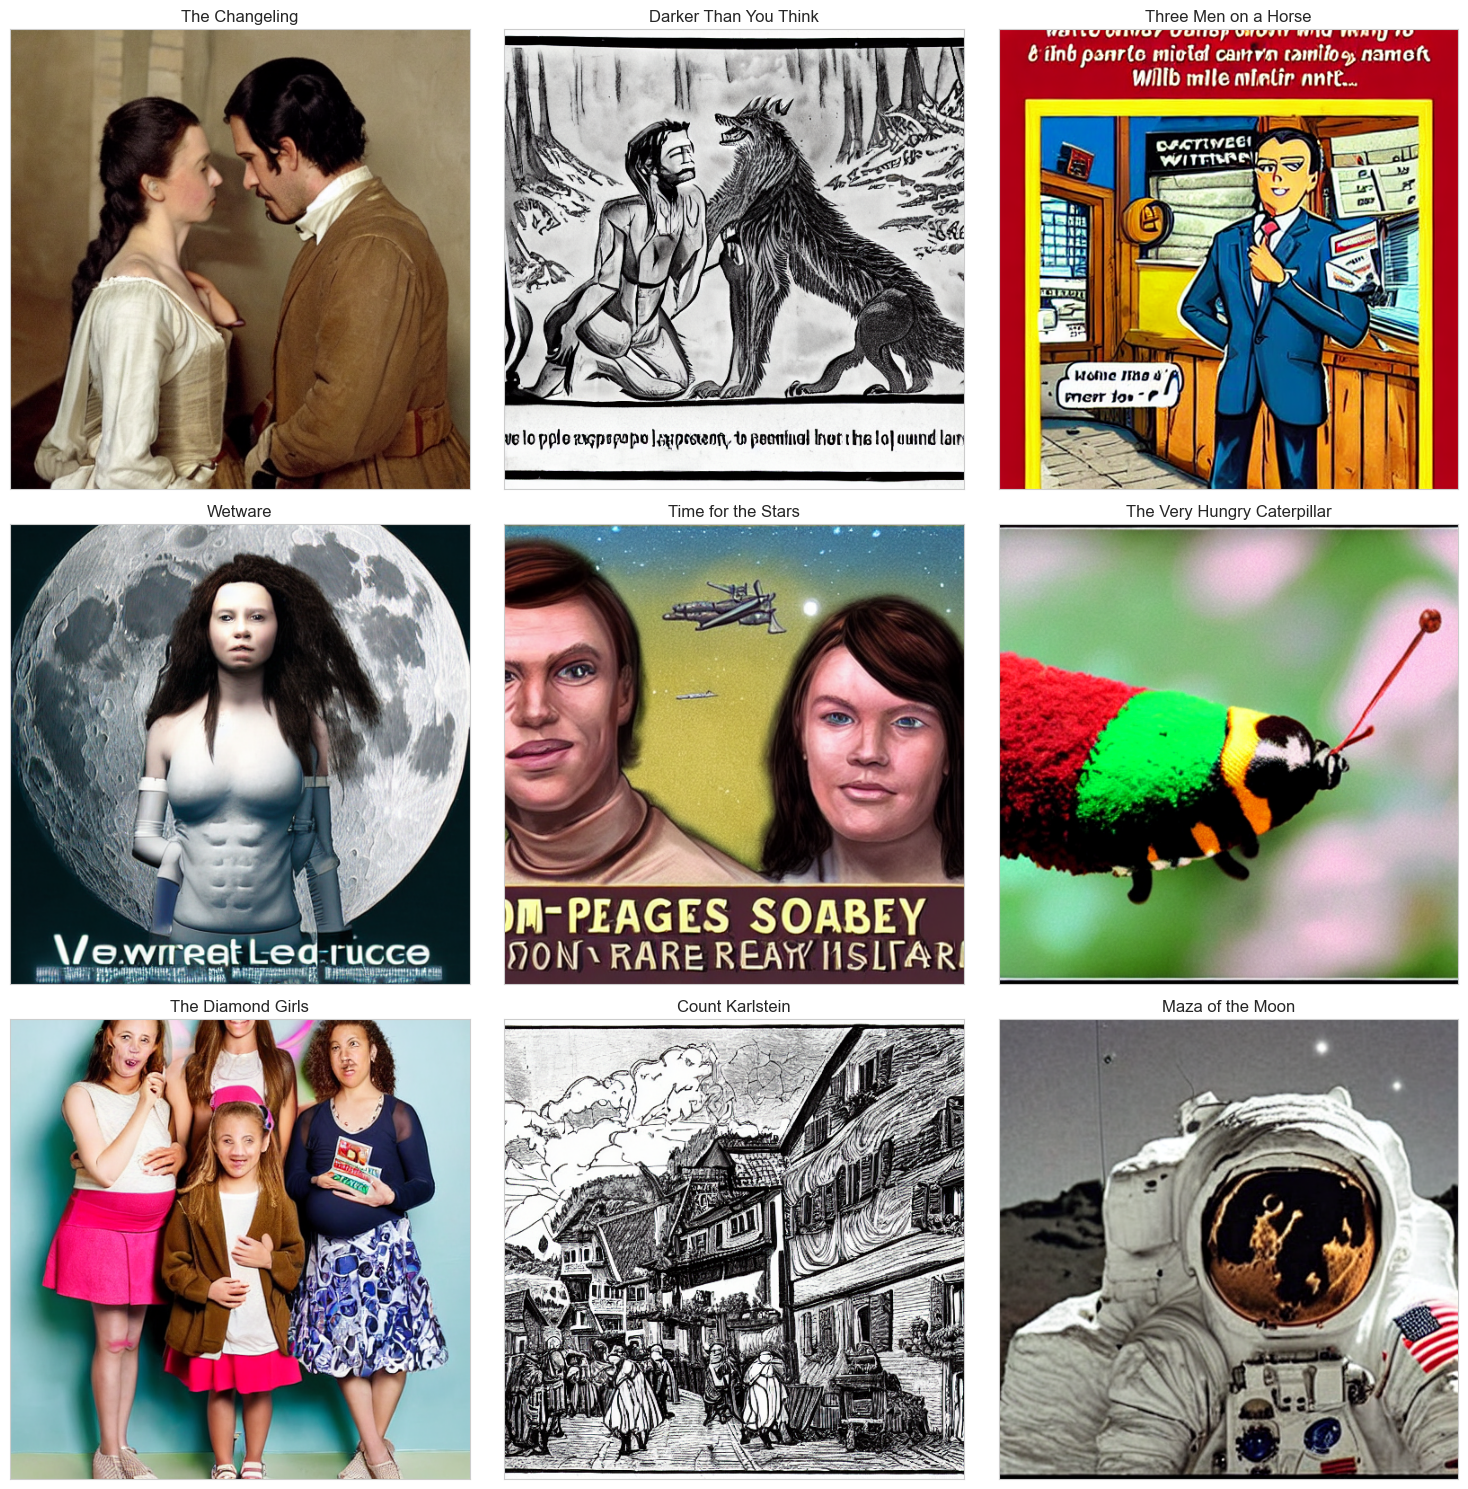

In [132]:
import os
import random
import matplotlib.pyplot as plt
from matplotlib.image import imread

directory = 'images/'

images = os.listdir(directory)

selected_images = random.sample(images, 9)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for ax, img_name in zip(axes, selected_images):
    img_path = os.path.join(directory, img_name)
    try:
        index = int(img_name.split('_')[0])
        img_name = df.iloc[index]['Title']


    except:
        index = int(img_name.split('.')[0])
        img_name = df.iloc[index]['Title']
    image = imread(img_path)
    ax.imshow(image)
    ax.set_title(img_name)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()
